In [3]:
import pandas as pd
import numpy as np
from rfpimp import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from fastai.imports import *

from matplotlib import pyplot as plt
import glob2 as glob
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

In [4]:

size_2015 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/size_2015*.csv')], ignore_index=True)
trip_2015 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/trip_2015*.csv')], ignore_index = True)

size_2016 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/size_2016*.csv')], ignore_index=True)
trip_2016 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/trip_2016*.csv')], ignore_index = True)

size_2017 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/size_2017*.csv')], ignore_index=True)
trip_2017 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/trip_2017*.csv')], ignore_index = True)

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (26,39,60,73,75) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (13,60,73) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (60) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (13,26,39,65,73) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yie

Many of the ID codes are messed up and aren't actually numbers...they end in XX instead. We will make these into NaN

In [5]:

trips = [trip_2017, trip_2016, trip_2015]
for trip in trips:
    ids=[]
    for idno in trip.ID_CODE:
        try: ids.append(int(idno))
        except: ids.append(np.nan)
    trip['new_id']=ids

In [4]:
# trip_2017['new_id']=ids
sum(trip_2015.new_id.isnull())

100

## Choose the columns that aren't obviously cheating:


In [5]:
# new_cols = ['prim1_common','SUB_REG','DIST','AREA','CNTY','ST','AREA_X','MODE_FX','BOAT_HRS',
#             'month','PARTY','CNTRBTRS','FFDAYS12','GEAR','common']

In [6]:
size_cols = ['AREA_X', 'ID_CODE', 'MODE_FX', 'ST', 'SUB_REG', 'YEAR', 'common']
trip_cols = ['prim1_common', 'AREA', 'BOAT_HRS', 'CNTRBTRS','CNTY','DIST',
            'FFDAYS12', 'GEAR', 'new_id','month','PARTY']

In [7]:
size2015 = size_2015[size_cols].copy()
trip2015 = trip_2015[trip_cols].copy()

size2016 = size_2016[size_cols].copy()
trip2016 = trip_2016[trip_cols].copy()

size2017 = size_2017[size_cols].copy()
trip2017 = trip_2017[trip_cols].copy()


In [8]:
merged2017 = pd.merge(size2017,trip2017,how='inner', left_on=['ID_CODE'], right_on=['new_id'])
merged2016 = pd.merge(size2016,trip2016,how='inner', left_on=['ID_CODE'], right_on=['new_id'])
merged2015 = pd.merge(size2015,trip2015,how='inner', left_on=['ID_CODE'], right_on=['new_id'])

In [9]:
print(sum(merged2016.common.isnull()))
print(len(merged2016.common))

33914
180049


In [10]:
#add all of the fish for the past 3 years together into one dataframe
total = pd.concat([merged2015,merged2016,merged2017])

Drop the fish that you don't have any name for. We can't use these for training.

In [11]:
mask = total.common.isnull()
data = total[mask==False].copy()

In [12]:
data.shape

(424320, 18)

fill the NA values of "primary fish sought" using "NONE" for NA values

In [13]:
data.prim1_common.fillna(value='NONE', inplace=True)

Drop the ID_CODE column and anything else that is leaky data

In [14]:
data.drop(columns=['new_id', 'ID_CODE'], inplace=True)

In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
AREA_X,424320.0,3.303236,1.626634,1.0,2.0,4.0,5.0,5.0
MODE_FX,424320.0,5.447714,1.438672,3.0,4.0,5.0,7.0,7.0
ST,424320.0,23.955713,13.758079,1.0,12.0,24.0,36.0,51.0
SUB_REG,424320.0,5.666118,1.157746,4.0,5.0,6.0,7.0,7.0
YEAR,424320.0,2016.009684,0.809636,2015.0,2015.0,2016.0,2017.0,2017.0
BOAT_HRS,238706.0,6.601046,3.754274,0.0,4.5,6.0,8.5,99.9
CNTRBTRS,424320.0,2.283633,2.090122,0.0,1.0,1.0,3.0,30.0
CNTY,424320.0,78.034382,145.267450,1.0,11.0,47.0,91.0,810.0
DIST,424320.0,4.532344,2.998930,1.0,2.0,4.0,8.0,8.0
FFDAYS12,424320.0,38.387495,125.989945,0.0,0.0,6.0,30.0,999.0


To DO: FILLNA for new_list (is the vehicle on a list?)
FILLNA FOR PARTY
FILLNA FOR HRSF
FILLNA FOR GEAR, BOAT HRS

This should all be taken care of by proc_df

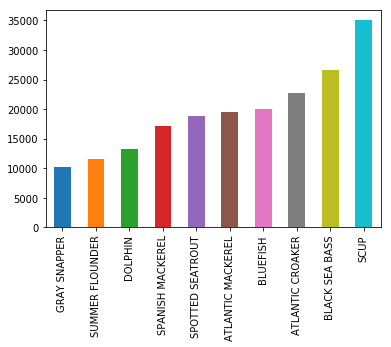

In [16]:
counts = data['common'].value_counts()
counts.sort_values(inplace=True)

counts[-10:].plot(kind='bar')

In [17]:
fish = counts.sum()
rates = [x/fish*100 for x in counts]
rates[-10:]

[2.4078525641025643,
 2.7212952488687785,
 3.108974358974359,
 4.035162141779789,
 4.4572492458521875,
 4.601244343891403,
 4.725207390648567,
 5.364111990950226,
 6.287707390648567,
 8.250848416289593]

In [18]:
def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1


In [20]:
train_cats(data)
df, y, nas = proc_df(data, 'common')

In [21]:
df.columns

Index(['AREA_X', 'MODE_FX', 'ST', 'SUB_REG', 'YEAR', 'prim1_common', 'AREA',
       'BOAT_HRS', 'CNTRBTRS', 'CNTY', 'DIST', 'FFDAYS12', 'GEAR', 'month',
       'PARTY', 'BOAT_HRS_na', 'GEAR_na', 'PARTY_na'],
      dtype='object')

In [20]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 125000
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(data, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((299320, 18), (299320,), (125000, 18))

In [21]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [ ]:
m = RandomForestClassifier()
%time m.fit(X_train, y_train)
print_score(m)

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 9.78 s, sys: 7.06 s, total: 16.8 s
Wall time: 2min


In [31]:
# imp = importances(m, X_valid, y_valid, n_samples=-1)
# viz = plot_importances(imp)
# viz.view()

In [32]:
# imp

Ok, so some of these features are actually _detrimental_ to predicting fish species. One of them is the number of days that you've been fishing in the past 2 months. Another is whether it's on the vehicle directory or not. Weirdly, the absence of a response had some predictive power. But we'll just remove the variable so that we have an intuitive and useful model.

In [23]:
## new columns to use
new_cols = ['prim1_common','SUB_REG','DIST','AREA','CNTY','ST','AREA_X','MODE_FX','BOAT_HRS',
            'month','PARTY','CNTRBTRS','FFDAYS12','GEAR','common']
data2=data[new_cols].copy()

In [24]:
data2.head()

,prim1_common,SUB_REG,DIST,AREA,CNTY,ST,AREA_X,MODE_FX,BOAT_HRS,month,PARTY,CNTRBTRS,FFDAYS12,GEAR,common
9,NONE,4,8.0,C,1.0,9,5,3,NaN,9,NaN,1.0,100.0,3.0,ATLANTIC SILVERSIDE
13,BLUEFISH,4,8.0,C,9.0,9,5,3,NaN,9,NaN,1.0,20.0,1.0,ATLANTIC MENHADEN
14,BLUEFISH,4,8.0,C,9.0,9,5,3,NaN,9,NaN,1.0,20.0,1.0,ATLANTIC MENHADEN
15,BLUEFISH,4,8.0,C,9.0,9,5,3,NaN,9,NaN,1.0,20.0,1.0,ATLANTIC MENHADEN
16,BLUEFISH,4,8.0,C,9.0,9,5,3,NaN,9,NaN,1.0,20.0,1.0,ATLANTIC MENHADEN


In [25]:
train_cats(data2)
df2, y2, nas2 = proc_df(data2, 'common')

In [26]:
n_valid = 53000
n_trn = len(df2)-n_valid
raw_train, raw_valid = split_vals(data2, n_trn)
X_train, X_valid = split_vals(df2, n_trn)
y_train, y_valid = split_vals(y2, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((88147, 17), (88147,), (53000, 17))

In [27]:
# m2 = RandomForestClassifier(n_jobs=-1)
# %time m2.fit(X_train, y_train)
# print_score(m2)

In [29]:
m3 = RandomForestClassifier(n_estimators=20,n_jobs=-1)
%time m3.fit(X_train, y_train)
print_score(m3)

CPU times: user 4.32 s, sys: 1.16 s, total: 5.48 s
Wall time: 56.3 s
[34.856944337864036, 48.987104001875494, 0.7873779028214233, 0.3969433962264151]


evaluate the model

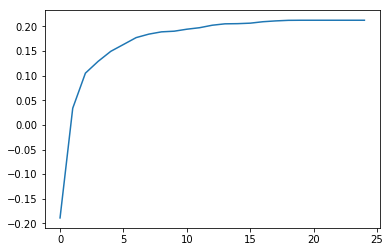

In [30]:
from sklearn import metrics
#get a list of all the trees (estimators), call predict on it. list of arrays(all predictions of one tree) of predictions 
#then concat them on an axis
preds = np.stack([t.predict(X_valid) for t in m3.estimators_])
#take the mean of all the predictions
preds[:,0], np.mean(preds[:,0]), y_valid[0]

#take the mean of the prediction, taking trees up to the i-th tree. 
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(25)]);

If we look at how adding more trees affects the accuracy, it is clear that adding lots more trees isn't making it better. Let's go back to the default of 10 or just stick with 20

In [31]:
# preds = np.stack([t.predict(X_valid) for t in m2.estimators_])

# preds[:,0], np.mean(preds[:,0]), y_valid[0]

# plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(25)]);

In [63]:
m4 = RandomForestRegressor(n_estimators=20, n_jobs=-1, oob_score=True)
m4.fit(X_train, y_train)
print_score(m4)

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[56.082279668762624, 87.61864386037686, 0.6903535767096948, 0.23155747708890517, 0.5368629619227605]


In [46]:
# test = m.predict_proba(porg2)

In [47]:
# probs_test_x = X_valid.loc[108660]
# porg = array(probs_test_x)
# porg2=porg.reshape(1,-1)

In [48]:
# corr = merged.corr()


In [49]:
# import seaborn as sns
# f , ax = plt.subplots(figsize = (14,12))

# plt.title('Correlation Matrix',y=1,size=16)

# sns.heatmap(corr,square = False,  vmax=0.8)

In [50]:
# import pickle 

# with open('model.pkl','wb') as pickle_file:
#     pickle.dump(m, pickle_file)

In [40]:
# print(raw_train.common.cat.codes.head(20))
# print(raw_train.common.head(20))

In [41]:
# data.common.cat.codes.unique()

In [42]:
# data.common.unique()

In [43]:
# mapping = pd.DataFrame()
# mapping['common_name']=data.common.unique()
# mapping['code']=data.common.cat.codes.unique()

In [44]:
# mapping.to_csv('name_map.csv', index=False)

In [45]:
# mapping.head()

In [51]:
# mapping = pd.read_csv('name_map.csv',index_col='common_name')

In [52]:
# mapping.head()

In [53]:
# mapping.columns

In [54]:
# mapping.loc['BLUEFISH', 'code']

In [55]:
# mapping.index

In [56]:
# mapping.loc[mapping['code'] == 23].index
